# **Facial Emotion Recognition**






Dataset - https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Dataset**
* The data consists of 48x48 pixel grayscale images of faces.

* The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
* Dataset contains two columns, "emotion" and "pixels".
* The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image.
* The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

# Data Visualization

* powerful visualization tools => matplotlib, seaborn
      1. matplotlib works on pandas dataframe
      2.  matplotlib => basic ploting =>bars,pie,scatter, lines etc.. => used for MATLAB like graphs
      3. seaborn => statistical ploting => depends on matplotlib...high level => provides default templates

In [ ]:
""" IMPORT ALL DEPENDENCIES"""



import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Facial Emotion Recognition /fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
df.shape

(35887, 3)

## **Plotting emotion**

<Axes: xlabel='emotion', ylabel='count'>

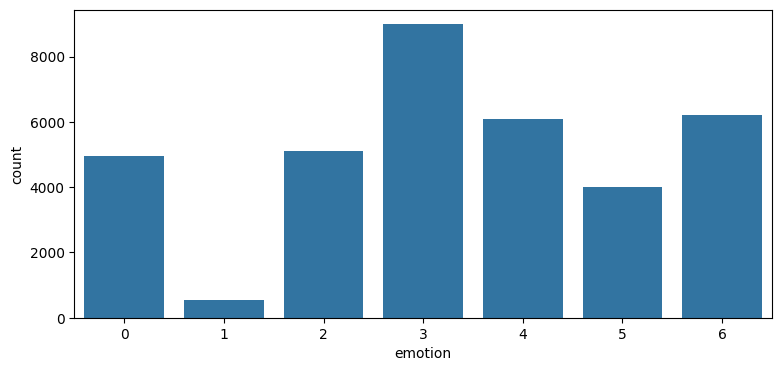

In [ ]:
""" matplotlib => to define size , sns => to use counterplot """

plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [ ]:
df['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


* where ** 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral**

### Observation
* for Digust we have about 547 images only very less.

## **Plotting Usage**

<Axes: xlabel='Usage', ylabel='count'>

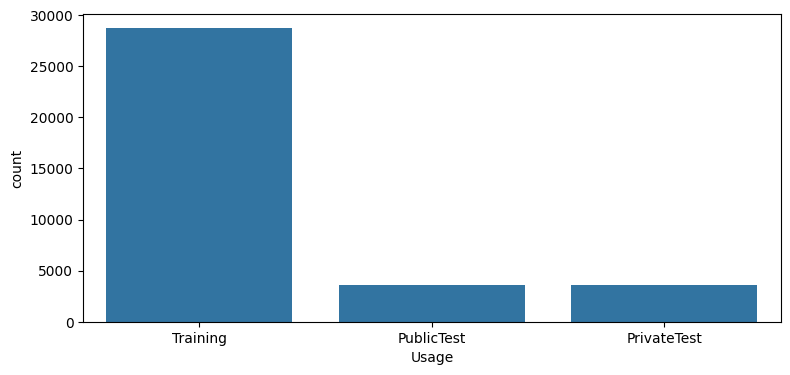

In [ ]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=df)

In [ ]:
df['Usage'].value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


 **Intuition**

* % matplotlib inline ==> magic cmd to setup IPython to display and store figures in notebooks
* dataframe ==>pd.read_csv() , .head(), .tail(), .shape
* count ==>  sns.countplot(x=,df) -> for graphs  ; df[col].value_counts() -> to display count values


# PreProcessing

In [ ]:
# Step 2: parse into a *new* column
def preprocess_pixels(pix_str):
    if not isinstance(pix_str, str):
        return None
    vals = pix_str.strip().split()           # split on whitespace
    if len(vals) != 48*48:
        return None
    arr = np.array(vals, dtype='float32')
    return arr.reshape(48, 48, 1)            # no /255 here

df['pixels_array'] = df['pixels'].apply(preprocess_pixels)

# Step 3: drop only the rows that truly failed parsing
df = df.dropna(subset=['pixels_array'])

# Step 4: stack that new column
X = np.stack(df['pixels_array'].tolist(), axis=0)
y = to_categorical(df['emotion'], num_classes=7)

In [ ]:
print("Shape of X:", X.shape)

Shape of X: (35887, 48, 48, 1)


In [ ]:
print("Type of X:", type(X))

Type of X: <class 'numpy.ndarray'>


In [ ]:
print("First image in X:", X[0])

First image in X: [[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]


In [ ]:
print("Number of dimensions in X[0]:", X[0].ndim)

Number of dimensions in X[0]: 3


In [ ]:
print("Shape of y:", y.shape)

Shape of y: (35887, 7)


In [ ]:
print("Type of y:", type(y))

Type of y: <class 'numpy.ndarray'>


In [ ]:
print("First label in y:", y[0])

First label in y: [1. 0. 0. 0. 0. 0. 0.]


In [ ]:
print("Number of dimensions in y:", y.ndim)

Number of dimensions in y: 2


In [ ]:
import numpy as np

# convert one-hot vectors back to integer labels
labels = np.argmax(y, axis=1)

# count how many samples you have of each label
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# map numeric labels to FER emotion names
emotion_map = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

for label, count in label_counts.items():
    print(f"{emotion_map.get(label, label)}: {count} samples")


Angry: 4953 samples
Disgust: 547 samples
Fear: 5121 samples
Happy: 8989 samples
Sad: 6077 samples
Surprise: 4002 samples
Neutral: 6198 samples


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 1. Integer labels
labels = np.argmax(y, axis=1)

# 2. Set up augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 3. Grab your 4 Disgust examples (label == 1)
idx_disgust = np.where(labels == 1)[0]
X_disgust = X[idx_disgust]
y_disgust = y[idx_disgust]   # <-- use idx_disgust here, not idx_dis

# 4. Generate ~80 new Disgust images
aug_X, aug_y = [], []
target_aug = 80
for img, onehot in zip(X_disgust, y_disgust):
    batch = img.reshape((1,)+img.shape)    # datagen needs a batch dim
    for new_img in datagen.flow(batch, batch_size=1):
        aug_X.append(new_img[0])
        aug_y.append(onehot)
        if len(aug_X) >= target_aug:
            break
    if len(aug_X) >= target_aug:
        break

aug_X = np.array(aug_X)
aug_y = np.array(aug_y)

# 5. Stack back onto original data
X = np.vstack([X, aug_X])
y = np.vstack([y, aug_y])

# 6. verify new counts
new_labels = np.argmax(y, axis=1)
unique, counts = np.unique(new_labels, return_counts=True)
print("Post-augmentation class counts:")
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt} samples")


Post-augmentation class counts:
  Class 0: 4953 samples
  Class 1: 627 samples
  Class 2: 5121 samples
  Class 3: 8989 samples
  Class 4: 6077 samples
  Class 5: 4002 samples
  Class 6: 6198 samples


# Splitting the dataset

In [ ]:
# First, perform the train-test (or train-validation) split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

In [ ]:
# Convert grayscale to RGB by replicating the channel
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

#resize

# import cv2
# X_train_resized = np.stack([
#     cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
#     for img in X_train_rgb
# ], axis=0)
# X_val_resized = np.stack([
#     cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
#     for img in X_val_rgb
# ], axis=0)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define basic data generator
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # zoom_range=0.1,
    # shear_range=0.1,
    # brightness_range=(0.9, 1.1),
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    # preprocessing_function=None  # We'll apply preprocess_input separately after MixUp/CutMix
)

# Define MixUp function
def mixup(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    return lam * X + (1 - lam) * X[idx], lam * y + (1 - lam) * y[idx]

# Define CutMix function
def cutmix(X, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))

    batch_size, h, w, _ = X.shape
    rx = np.random.randint(w)
    ry = np.random.randint(h)
    rw = int(w * np.sqrt(1 - lam))
    rh = int(h * np.sqrt(1 - lam))

    x1 = np.clip(rx - rw // 2, 0, w)
    y1 = np.clip(ry - rh // 2, 0, h)
    x2 = np.clip(rx + rw // 2, 0, w)
    y2 = np.clip(ry + rh // 2, 0, h)

    X_new = np.copy(X)
    for i in range(batch_size):
        X_new[i, y1:y2, x1:x2, :] = X[idx[i], y1:y2, x1:x2, :]

    lam_adjusted = 1 - ((x2 - x1) * (y2 - y1)) / (w * h)
    y_new = lam_adjusted * y + (1 - lam_adjusted) * y[idx]

    return X_new, y_new

# Hybrid MixUp + CutMix Generator
def hybrid_mixup_cutmix_resize_generator(datagen, X, y, batch_size=64, target_size=(224, 224)):
    while True:
        for batch_X, batch_y in datagen.flow(X, y, batch_size=batch_size):
            # Resize images to target size
            resized_X = np.array([cv2.resize(img, target_size) for img in batch_X])
            if np.random.rand() < 0.1:   # 30% chance MixUp, 70% CutMix then 10-90
                Xb, yb = mixup(resized_X, batch_y)
            else:
                Xb, yb = cutmix(resized_X, batch_y)
            # Preprocess images before returning
            yield preprocess_input(Xb), yb

# Train generator (with hybrid augmentations)
train_generator = hybrid_mixup_cutmix_resize_generator(
    train_datagen,
    X_train_rgb,
    y_train,
    batch_size=64,
    target_size=(224, 224)
)


In [ ]:
# Resize Generator for Validation
def resize_generator(datagen, X, y, batch_size=64, target_size=(224, 224)):
    while True:
        for batch_X, batch_y in datagen.flow(X, y, batch_size=batch_size, shuffle=False):
            resized_X = np.array([cv2.resize(img, target_size) for img in batch_X])
            yield resized_X, batch_y


# Validation Data Generator (no geometric augmentation, but same scaling)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_generator = resize_generator(
    val_datagen,
    X_val_rgb,
    y_val,
    batch_size=64,
    target_size=(224,224)
)

In [ ]:
print("Shape of RGB training data:", X_train_rgb.shape)
print("Shape of RGB validation data:", X_val_rgb.shape)
print("Shape of RGB validation data:", X_val_rgb.shape)

Shape of RGB training data: (28773, 48, 48, 3)
Shape of RGB validation data: (7194, 48, 48, 3)
Shape of RGB validation data: (7194, 48, 48, 3)


In [ ]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of y_train: (28773, 7)
Shape of y_val: (7194, 7)


In [ ]:
# Check the pixel value range after scaling for the training set
print("\nPixel value range in X_train_rgb:")
print("Min:", X_train_rgb.min())
print("Max:", X_train_rgb.max())


Pixel value range in X_train_rgb:
Min: 0.0
Max: 255.0


In [ ]:
# Check the pixel value range after scaling for the validation set
print("\nPixel value range in X_val_scaled:")
print("Min:", X_val_rgb.min())
print("Max:", X_val_rgb.max())


Pixel value range in X_val_scaled:
Min: 0.0
Max: 255.0


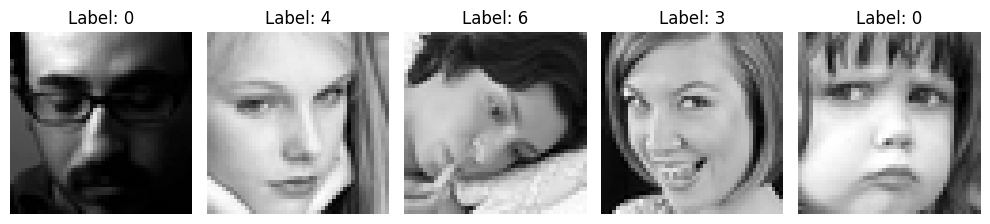

In [ ]:
# Visualize a few of the scaled training images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].reshape(48, 48), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Defining Model

In [ ]:
num_classes = 7
input_shape = (224, 224, 3)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation, Conv1D, Reshape, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

# ECA block
def eca_block(input_tensor, gamma=2, b=1):
    # 1) Squeeze: global average pool, shape=(batch, C)
    x = GlobalAveragePooling2D()(input_tensor)
    x = Reshape((-1, 1))(x)  # shape=(batch, C, 1)

    # 2) Compute adaptive kernel size
    channels = input_tensor.shape[-1]
    t = int(abs((tf.math.log(tf.cast(channels, tf.float32))
                  / tf.math.log(2.0) + b) / gamma))
    k = t if t % 2 else t + 1  # make sure k is odd

    # 3) 1D conv for cross-channel interaction
    x = Conv1D(1, kernel_size=k, padding='same', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((1, 1, channels))(x)  # shape=(batch, 1, 1, C)

    # 4) Scale the input feature map
    return multiply([input_tensor, x])


# Load the pre-trained ResNet50 model, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few convolutional blocks for fine-tuning
for layer in base_model.layers[-50:]:  # You can adjust how many layers to unfreeze
    layer.trainable = True

# Add custom classification layers on top
x = base_model.output
x = eca_block(x)
x = GlobalAveragePooling2D()(x)

# First Dense block with L2 regularization, Batch Normalization, and Dropout
x = Dense(512, kernel_regularizer=l2(1e-4))(x)  # L2 Regularization
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Second Dense block with L2 regularization, Batch Normalization, and Dropout
x = Dense(256, kernel_regularizer=l2(1e-4))(x)  # L2 Regularization
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.6)(x)

# Output layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with label smoothing and a smaller learning rate
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,773,006 (94.50 MB)

 Trainable params: 18,134,286 (69.18 MB)

 Non-trainable params: 6,638,720 (25.32 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

# 1) Convert one-hot labels to class indices
y_indices = np.argmax(y_train, axis=1)

# 2) Compute class weights
# class_weights = dict(enumerate(
#     compute_class_weight(
#         class_weight='balanced',
#         classes=np.unique(y_indices),
#         y=y_indices
#     )
# ))

# Define EarlyStopping callback (monitor val_loss to avoid overfitting)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# 4) (Optional) Define ReduceLROnPlateau callback (commented out for now)
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-7,
#     verbose=1
# )

# Define ModelCheckpoint callback to save the best model based on val_accuracy
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 6) Learning-rate schedule and optimizer (CosineDecay + AdamW)
steps_per_epoch = len(X_train_rgb) // 64
total_steps = steps_per_epoch * 30  # for 30 epochs

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps,
    alpha=1e-6
)

from tensorflow.keras.optimizers import Adam
optimizer = Adam( learning_rate=lr_schedule)

# 7) Loss with label smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# 8) Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)


In [ ]:
# # Train the model
# # epochs = 50  # You can adjust the number of epochs
# # batch_size = 32 # You can adjust the batch size
# steps_per_epoch = len(X_train_rgb) // 64
# history2 = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=30,
#     validation_data=val_generator,
#     validation_steps=len(X_val_rgb) // 64,
#     class_weights=class_weights,
#     callbacks=[early_stopping, lr_scheduler],
#     verbose=1
# )


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val_rgb) // 64,
    # class_weight=class_weights,
    # callbacks=[early_stopping],     # Only EarlyStopping needed if CosineDecay
    callbacks=[early_stopping,checkpoint],
    verbose=1
)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2349 - loss: 2.5156
Epoch 1: val_accuracy improved from -inf to 0.49135, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 166s 302ms/step - accuracy: 0.2350 - loss: 2.5151 - val_accuracy: 0.4914 - val_loss: 1.8988
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3516 - loss: 2.0081
Epoch 2: val_accuracy improved from 0.49135 to 0.53530, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 200s 417ms/step - accuracy: 0.3517 - loss: 2.0080 - val_accuracy: 0.5353 - val_loss: 1.6110
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.4061 - loss: 1.8923
Epoch 3: val_accuracy improved from 0.53530 to 0.55456, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.4061 - loss: 1.8923 - val_accuracy: 0.5546 - val_loss: 1.5652
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4289 - loss: 1.8447
Epoch 4: val_accuracy improved from 0.55456 to 0.56648, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 311ms/step - accuracy: 0.4289 - loss: 1.8446 - val_accuracy: 0.5665 - val_loss: 1.5125
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4606 - loss: 1.7910
Epoch 5: val_accuracy improved from 0.56648 to 0.59130, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 288ms/step - accuracy: 0.4606 - loss: 1.7910 - val_accuracy: 0.5913 - val_loss: 1.5185
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4828 - loss: 1.7456
Epoch 6: val_accuracy did not improve from 0.59130
449/449 ━━━━━━━━━━━━━━━━━━━━ 141s 314ms/step - accuracy: 0.4828 - loss: 1.7456 - val_accuracy: 0.5728 - val_loss: 1.4920
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4693 - loss: 1.7489
Epoch 7: val_accuracy improved from 0.59130 to 0.62987, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 290ms/step - accuracy: 0.4693 - loss: 1.7489 - val_accuracy: 0.6299 - val_loss: 1.3834
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5109 - loss: 1.6889
Epoch 8: val_accuracy improved from 0.62987 to 0.63829, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 288ms/step - accuracy: 0.5109 - loss: 1.6889 - val_accuracy: 0.6383 - val_loss: 1.3684
Epoch 9/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5241 - loss: 1.6838
Epoch 9: val_accuracy did not improve from 0.63829
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - accuracy: 0.5241 - loss: 1.6838 - val_accuracy: 0.6241 - val_loss: 1.3717
Epoch 10/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5265 - loss: 1.6612
Epoch 10: val_accuracy improved from 0.63829 to 0.64222, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 143s 319ms/step - accuracy: 0.5265 - loss: 1.6612 - val_accuracy: 0.6422 - val_loss: 1.3472
Epoch 11/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5328 - loss: 1.6419
Epoch 11: val_accuracy improved from 0.64222 to 0.65666, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 317ms/step - accuracy: 0.5328 - loss: 1.6419 - val_accuracy: 0.6567 - val_loss: 1.3057
Epoch 12/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5571 - loss: 1.6215
Epoch 12: val_accuracy did not improve from 0.65666
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - accuracy: 0.5571 - loss: 1.6216 - val_accuracy: 0.6526 - val_loss: 1.3021
Epoch 13/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5606 - loss: 1.6074
Epoch 13: val_accuracy improved from 0.65666 to 0.67125, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 290ms/step - accuracy: 0.5606 - loss: 1.6074 - val_accuracy: 0.6712 - val_loss: 1.2823
Epoch 14/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5808 - loss: 1.5751
Epoch 14: val_accuracy did not improve from 0.67125
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - accuracy: 0.5808 - loss: 1.5751 - val_accuracy: 0.6670 - val_loss: 1.3254
Epoch 15/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5778 - loss: 1.5823
Epoch 15: val_accuracy improved from 0.67125 to 0.67153, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 288ms/step - accuracy: 0.5778 - loss: 1.5823 - val_accuracy: 0.6715 - val_loss: 1.2686
Epoch 16/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5971 - loss: 1.5627
Epoch 16: val_accuracy improved from 0.67153 to 0.67812, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 293ms/step - accuracy: 0.5971 - loss: 1.5627 - val_accuracy: 0.6781 - val_loss: 1.2639
Epoch 17/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5991 - loss: 1.5407
Epoch 17: val_accuracy did not improve from 0.67812
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 309ms/step - accuracy: 0.5991 - loss: 1.5407 - val_accuracy: 0.6728 - val_loss: 1.2523
Epoch 18/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6069 - loss: 1.5312
Epoch 18: val_accuracy did not improve from 0.67812
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - accuracy: 0.6069 - loss: 1.5311 - val_accuracy: 0.6741 - val_loss: 1.2660
Epoch 19/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6094 - loss: 1.5205
Epoch 19: val_accuracy improved from 0.67812 to 0.68471, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 300ms/step - accuracy: 0.6094 - loss: 1.5205 - val_accuracy: 0.6847 - val_loss: 1.2306
Epoch 20/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6240 - loss: 1.5121
Epoch 20: val_accuracy improved from 0.68471 to 0.68527, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 138s 308ms/step - accuracy: 0.6240 - loss: 1.5121 - val_accuracy: 0.6853 - val_loss: 1.2270
Epoch 21/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6240 - loss: 1.5184
Epoch 21: val_accuracy improved from 0.68527 to 0.68990, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 141s 314ms/step - accuracy: 0.6240 - loss: 1.5184 - val_accuracy: 0.6899 - val_loss: 1.2131
Epoch 22/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6419 - loss: 1.4777
Epoch 22: val_accuracy did not improve from 0.68990
449/449 ━━━━━━━━━━━━━━━━━━━━ 140s 313ms/step - accuracy: 0.6418 - loss: 1.4778 - val_accuracy: 0.6872 - val_loss: 1.2153
Epoch 23/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6294 - loss: 1.5007
Epoch 23: val_accuracy did not improve from 0.68990
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step - accuracy: 0.6294 - loss: 1.5007 - val_accuracy: 0.6888 - val_loss: 1.2141
Epoch 24/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6464 - loss: 1.4625
Epoch 24: val_accuracy did not improve from 0.68990
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step - accuracy: 0.6464 - loss: 1.4625 - val_accuracy: 0.6870 - val_loss: 1.2218
Epoch 25/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6435 - loss: 1.4788
Epoc

449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 331ms/step - accuracy: 0.6510 - loss: 1.4578 - val_accuracy: 0.6909 - val_loss: 1.2192
Epoch 28/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6475 - loss: 1.4762
Epoch 28: val_accuracy did not improve from 0.69088
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.6475 - loss: 1.4762 - val_accuracy: 0.6898 - val_loss: 1.2181
Epoch 29/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6468 - loss: 1.4738
Epoch 29: val_accuracy improved from 0.69088 to 0.69130, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.6468 - loss: 1.4738 - val_accuracy: 0.6913 - val_loss: 1.2140
Epoch 30/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6411 - loss: 1.4802
Epoch 30: val_accuracy improved from 0.69130 to 0.69215, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.6412 - loss: 1.4802 - val_accuracy: 0.6921 - val_loss: 1.2158
Epoch 31/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6661 - loss: 1.4454
Epoch 31: val_accuracy did not improve from 0.69215
449/449 ━━━━━━━━━━━━━━━━━━━━ 195s 435ms/step - accuracy: 0.6661 - loss: 1.4454 - val_accuracy: 0.6914 - val_loss: 1.2193
Epoch 32/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6547 - loss: 1.4575
Epoch 32: val_accuracy did not improve from 0.69215
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step - accuracy: 0.6547 - loss: 1.4575 - val_accuracy: 0.6914 - val_loss: 1.2199
Epoch 33/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6489 - loss: 1.4677
Epoch 33: val_accuracy did not improve from 0.69215
449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 289ms/step - accuracy: 0.6489 - loss: 1.4677 - val_accuracy: 0.6907 - val_loss: 1.2186
Epoch 34/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6526 - loss: 1.4728
Epoc

449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 323ms/step - accuracy: 0.6568 - loss: 1.4433 - val_accuracy: 0.6924 - val_loss: 1.2154
Epoch 39/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6724 - loss: 1.4385
Epoch 39: val_accuracy did not improve from 0.69243
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 310ms/step - accuracy: 0.6724 - loss: 1.4385 - val_accuracy: 0.6920 - val_loss: 1.2210
Epoch 40/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6677 - loss: 1.4408
Epoch 40: val_accuracy improved from 0.69243 to 0.69271, saving model to best_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 330ms/step - accuracy: 0.6677 - loss: 1.4408 - val_accuracy: 0.6927 - val_loss: 1.2177
Epoch 41/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6596 - loss: 1.4496
Epoch 41: val_accuracy did not improve from 0.69271
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 302ms/step - accuracy: 0.6596 - loss: 1.4495 - val_accuracy: 0.6916 - val_loss: 1.2144
Epoch 42/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6523 - loss: 1.4559
Epoch 42: val_accuracy did not improve from 0.69271
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - accuracy: 0.6523 - loss: 1.4559 - val_accuracy: 0.6906 - val_loss: 1.2148
Epoch 43/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6596 - loss: 1.4547
Epoch 43: val_accuracy did not improve from 0.69271
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 288ms/step - accuracy: 0.6596 - loss: 1.4547 - val_accuracy: 0.6907 - val_loss: 1.2168
Epoch 44/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6626 - loss: 1.4438
Epoc

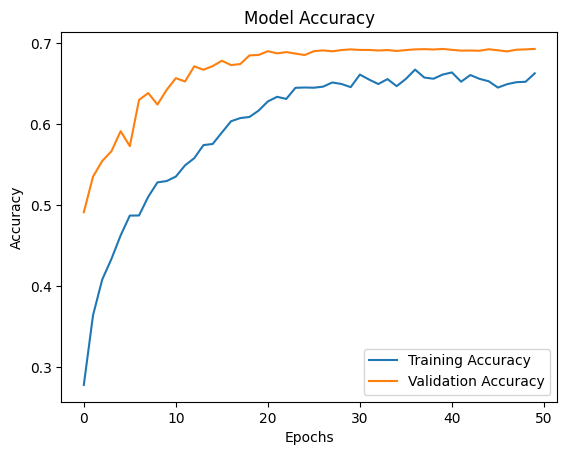

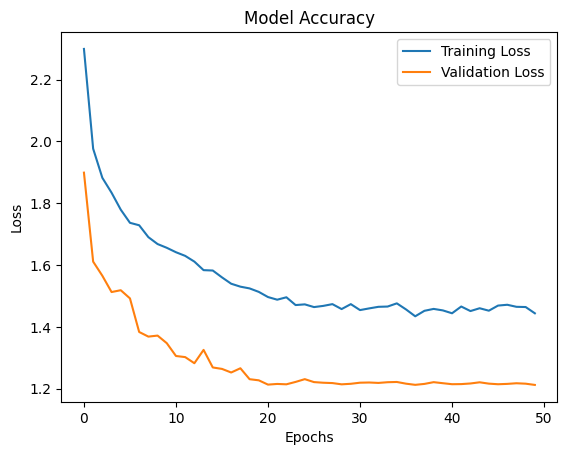

In [ ]:
# Example to plot the training and validation accuracy over epochs
#  import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")  # or use the correct path from ModelCheckpoint


In [ ]:
# Prepare the datasets
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, label

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_rgb, y_train))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_rgb, y_val))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Load the model
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

# Predict on training set and calculate accuracy
import numpy as np
from sklearn.metrics import accuracy_score

y_train_probs = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_probs, axis=1)
y_train_true = np.argmax(y_train, axis=1)
train_accuracy = accuracy_score(y_train_true, y_train_pred)

# Predict on validation set and calculate accuracy
y_val_probs = model.predict(val_dataset)
y_val_pred = np.argmax(y_val_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)
val_accuracy = accuracy_score(y_val_true, y_val_pred)

# Print both accuracy
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


900/900 ━━━━━━━━━━━━━━━━━━━━ 91s 96ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step
Training Accuracy: 0.8091
Validation Accuracy: 0.6914


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print scores
# print(f"Validation Accuracy : {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted)   : {recall:.4f}")
print(f"F1 Score (weighted) : {f1:.4f}")


Precision (weighted): 0.6974
Recall (weighted)   : 0.6914
F1 Score (weighted) : 0.6891


In [ ]:
# Full classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       991
           1       0.79      0.59      0.68       125
           2       0.64      0.43      0.51      1024
           3       0.90      0.87      0.89      1798
           4       0.59      0.59      0.59      1216
           5       0.77      0.80      0.79       800
           6       0.57      0.75      0.65      1240

    accuracy                           0.69      7194
   macro avg       0.70      0.66      0.67      7194
weighted avg       0.70      0.69      0.69      7194



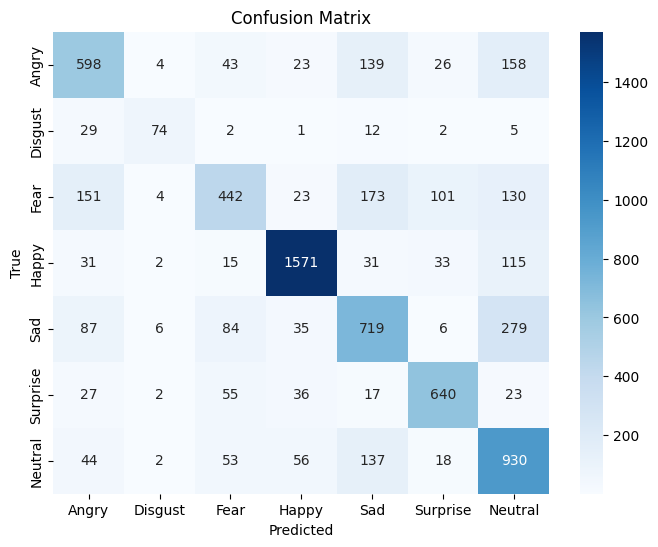

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names for FER2013
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Compute and plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


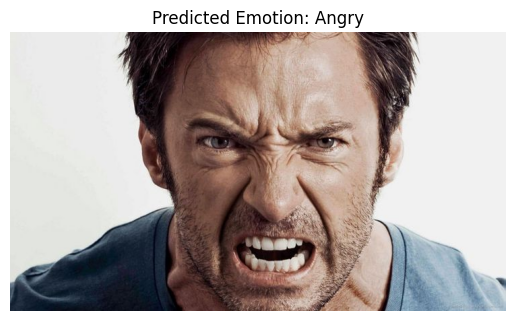

Predicted Class Index: 0
Predicted Emotion: Angry


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your trained model
model = load_model('best_model.h5')

# Load the image you uploaded
img_path = '/content/drive/MyDrive/Facial Emotion Recognition /img.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))
img_preprocessed = preprocess_input(img_resized.astype(np.float32))
img_batch = np.expand_dims(img_preprocessed, axis=0)  # Shape: (1, 224, 224, 3)

# Predict
pred_probs = model.predict(img_batch)
pred_class = np.argmax(pred_probs)

# Map index to emotion label
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']  # Adjust if needed
pred_label = class_labels[pred_class]

# Display result
plt.imshow(img_rgb)
plt.title(f"Predicted Emotion: {pred_label}")
plt.axis('off')
plt.show()

print(f"Predicted Class Index: {pred_class}")
print(f"Predicted Emotion: {pred_label}")
